<a href="https://colab.research.google.com/github/askmuhsin/Session_5_assignment/blob/main/Experiment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target:
* Increase LR to .025
* Background
  * Last model was trained on dataset with more augmentation, and therefore was taking more epochs to converge.
  * Now Trying with a higher learning rate, inorder to get desired accuracy within 15 epochs.

# Results:
* Parameters: 9,958
* Best Training Accuracy: 98.84% (EPOCH 15)
* Best Test Accuracy: 99.46% (EPOCH 14)

# Analysis:
*

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
import torchvision

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [36]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomAffine(
                                      #     degrees=0,
                                      #     scale=(0.8, 0.9),
                                      #     shear=3
                                      #  ),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [37]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [38]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


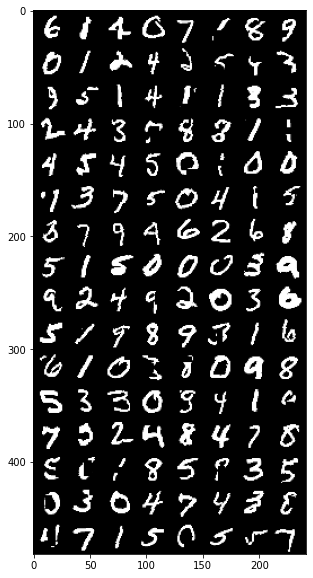

In [39]:
for data, target in train_loader:
  break
grid_img = torchvision.utils.make_grid(data.cpu().detach())
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

# The model
Let's start with the model we first saw

In [40]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=7, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

         # CONVOLUTION BLOCK 5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
         # CONVOLUTION BLOCK 6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 6
         # CONVOLUTION BLOCK 7
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        # self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        x = self.convblock3(x)
        x = self.pool1(x)

        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [41]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
       BatchNorm2d-3            [-1, 6, 26, 26]              12
           Dropout-4            [-1, 6, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 7, 24, 24]              84
        MaxPool2d-10            [-1, 7, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,008
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [42]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [43]:
# from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.020, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.20168669521808624 Batch_id=468 Accuracy=85.72: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0679, Accuracy: 9785/10000 (97.85%)

EPOCH: 1


Loss=0.15843304991722107 Batch_id=468 Accuracy=95.77: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.07036277651786804 Batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9870/10000 (98.70%)

EPOCH: 3


Loss=0.11776870489120483 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9865/10000 (98.65%)

EPOCH: 4


Loss=0.13411760330200195 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:17<00:00, 26.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9855/10000 (98.55%)

EPOCH: 5


Loss=0.21134382486343384 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:18<00:00, 26.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9895/10000 (98.95%)

EPOCH: 6


Loss=0.2454625815153122 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:17<00:00, 26.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


Loss=0.053908128291368484 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:18<00:00, 25.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.08431902527809143 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.09969386458396912 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.03811606019735336 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.031681690365076065 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9915/10000 (99.15%)

EPOCH: 12


Loss=0.04901520907878876 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.028481334447860718 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.01409014593809843 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:17<00:00, 26.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9919/10000 (99.19%)

EPOCH: 15


Loss=0.07156794518232346 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:18<00:00, 25.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.040292639285326004 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:18<00:00, 26.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.08226557075977325 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:18<00:00, 25.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.11663884669542313 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:18<00:00, 25.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.04275089129805565 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0180, Accuracy: 9938/10000 (99.38%)



# Let's Train and test our model

Text(0.5, 1.0, 'Test Accuracy')

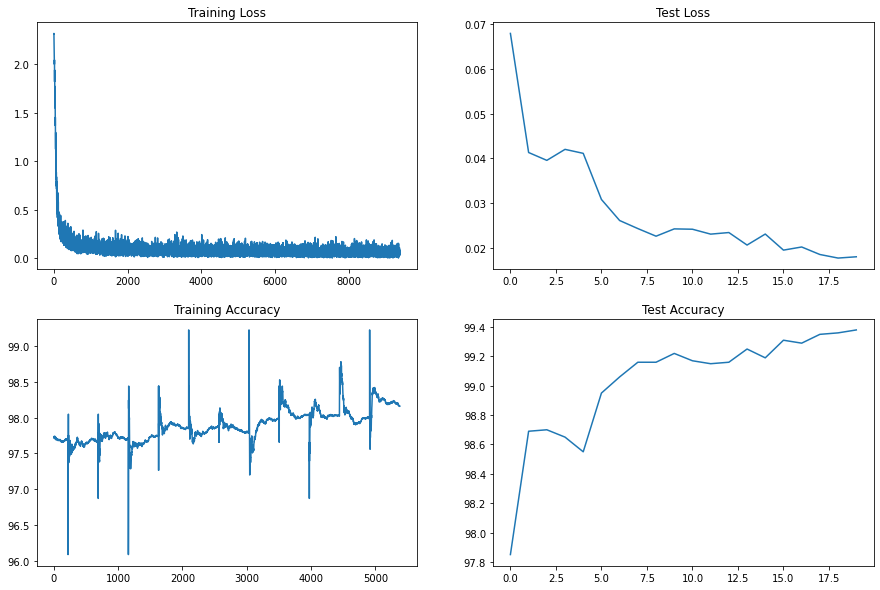

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [45]:
import pandas as pd

In [46]:
df = pd.DataFrame()
df['batch_avg_train_acc'] = pd.DataFrame(train_acc).rolling(469).mean().dropna()[::469].reset_index(drop=True)[0]
df['train_acc'] = pd.DataFrame(train_acc)[468::469].reset_index(drop=True)[0]
df['test_acc'] = pd.DataFrame(test_acc)
df['train_losses'] = pd.DataFrame([x.item() for x in train_losses])[468::469].reset_index(drop=True)[0]
df['test_losses'] = pd.DataFrame(test_losses)
df[['test_acc', 'train_acc', 'batch_avg_train_acc', 'train_losses', 'test_losses']]

,test_acc,train_acc,batch_avg_train_acc,train_losses,test_losses
0,97.85,85.718333,70.071563,0.201687,0.067919
1,98.69,95.771667,95.574490,0.158433,0.041316
2,98.70,96.565000,96.379698,0.070363,0.039561
3,98.65,96.953333,96.966673,0.117769,0.042020
4,98.55,97.101667,97.191430,0.134118,0.041129
5,98.95,97.430000,97.250564,0.211344,0.030827
6,99.06,97.466667,97.543110,0.245463,0.026121
7,99.16,97.495000,97.440106,0.053908,0.024324
8,99.16,97.698333,97.678917,0.084319,0.022621
9,99.22,97.660000,97.631068,0.099694,0.024253


In [47]:
max_test_epoch = 13
df[['test_acc', 'train_acc']][max_test_epoch - 3:max_test_epoch + 6]

,test_acc,train_acc
10,99.17,97.715000
11,99.15,97.741667
12,99.16,97.861667
13,99.25,97.888333
14,99.19,97.805000
15,99.31,97.986667
16,99.29,98.035000
17,99.35,98.021667
18,99.36,97.980000


In [48]:
df[:15].max()

batch_avg_train_acc    97.892972
train_acc              97.888333
test_acc               99.250000
train_losses            0.245463
test_losses             0.067919
dtype: float64

In [49]:
df.min()

batch_avg_train_acc    70.071563
train_acc              85.718333
test_acc               97.850000
train_losses            0.014090
test_losses             0.017736
dtype: float64

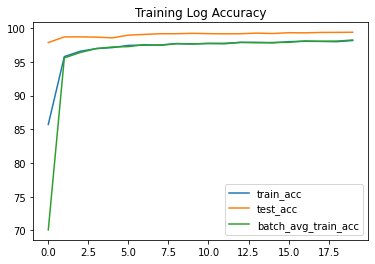

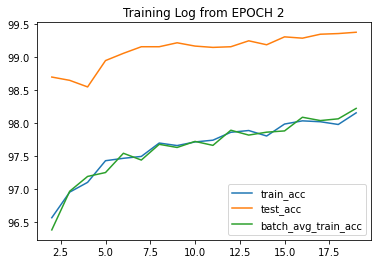

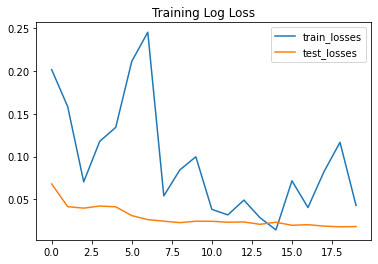

In [50]:
df[['train_acc', 'test_acc', 'batch_avg_train_acc']].plot(title="Training Log Accuracy")
df[['train_acc', 'test_acc', 'batch_avg_train_acc']][2:].plot(title="Training Log from EPOCH 2")
df[['train_losses', 'test_losses']].plot(title="Training Log Loss")

In [51]:
df[15:].var()

batch_avg_train_acc    0.014968
train_acc              0.005084
test_acc               0.001370
train_losses           0.000988
test_losses            0.000001
dtype: float64

In [52]:
## inspect data
model.eval()
test_loss = 0
correct = 0

wrong_correct = []
wrong_predicted = []
wrong_image_data = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        status = pred.eq(target.view_as(pred))
        # correct += status.sum().item()

        mistakes, _ = torch.where(status==False)
        if len(mistakes):
          m_data = data[mistakes]
          m_target = target[mistakes]
          m_output = output[mistakes]
          m_pred = pred[mistakes]
          correct = [x.item() for x in m_target.cpu().detach()]
          predicted = [x.item() for x in m_pred.cpu().detach()]
          image_data = [x for x in m_data.cpu().detach()]

          wrong_correct.extend(correct)
          wrong_predicted.extend(predicted)
          wrong_image_data.extend(image_data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [53]:
from collections import Counter

In [54]:
len(wrong_correct), len(wrong_predicted), len(wrong_image_data)

(62, 62, 62)

In [55]:
mskts = pd.DataFrame(Counter(wrong_correct).most_common(), columns=['number', 'number of times prediction error'])
mskts

,number,number of times prediction error
0,6,11
1,4,9
2,9,8
3,5,8
4,8,8
5,7,7
6,2,5
7,3,3
8,0,2
9,1,1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 6 || Mistakenly predicted as [1, 5, 0, 0, 8, 8, 1, 1, 0, 5, 0]


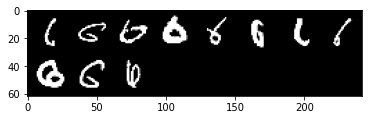

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 4 || Mistakenly predicted as [9, 9, 9, 9, 9, 9, 6, 8, 9]


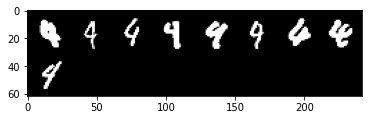

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 9 || Mistakenly predicted as [7, 4, 4, 5, 4, 4, 4, 7]


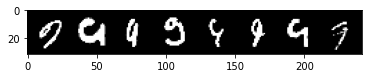

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 5 || Mistakenly predicted as [3, 3, 3, 6, 0, 3, 0, 3]


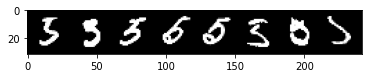

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 8 || Mistakenly predicted as [9, 3, 5, 5, 2, 9, 9, 0]


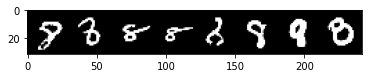


Correct Label -- 7 || Mistakenly predicted as [1, 1, 5, 2, 1, 1, 9]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


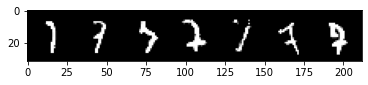

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 2 || Mistakenly predicted as [1, 7, 7, 7, 7]


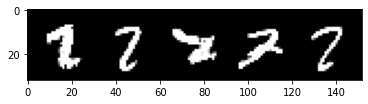

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 3 || Mistakenly predicted as [5, 5, 1]


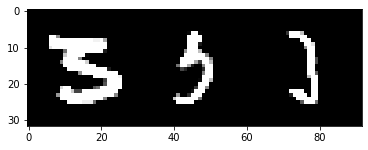

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 0 || Mistakenly predicted as [6, 7]


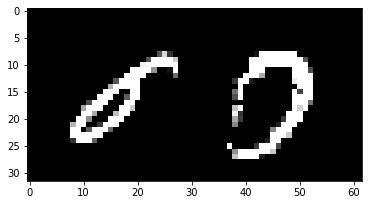

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 1 || Mistakenly predicted as [3]


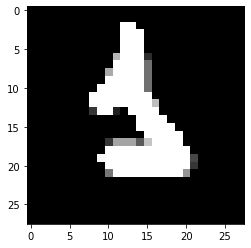

In [56]:
for select_num in mskts['number']:
  # select_num = 9
  img_data_temp = []
  wps = []
  for wc, wp, wi in zip(wrong_correct, wrong_predicted, wrong_image_data):
    if wc == select_num:
      wps.append(wp)
      img_data_temp.append(wi)

  wrong_images_temp = torch.stack(img_data_temp)
  print()
  print(f"Correct Label -- {select_num} || Mistakenly predicted as {wps}")

  grid_img = torchvision.utils.make_grid(wrong_images_temp)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()

In [ ]:
1